<a href="https://colab.research.google.com/github/YUGESH-R/MojorprojectML/blob/main/MLmojorproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⚠ Failed to load from https://raw.githubusercontent.com/plotly/datasets/master/Mall_Customers.csv
Error: HTTP Error 404: Not Found
 Successfully loaded data from:
https://raw.githubusercontent.com/krishnaik06/DBSCAN-Algorithm/master/Mall_Customers.csv

 Data Preview:


,customerid,genre,age,annual_income_k$,spending_score_1-100
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40



 Data Shape: (200, 5)

 Missing Values:
customerid              0
genre                   0
age                     0
annual_income_k$        0
spending_score_1-100    0
dtype: int64


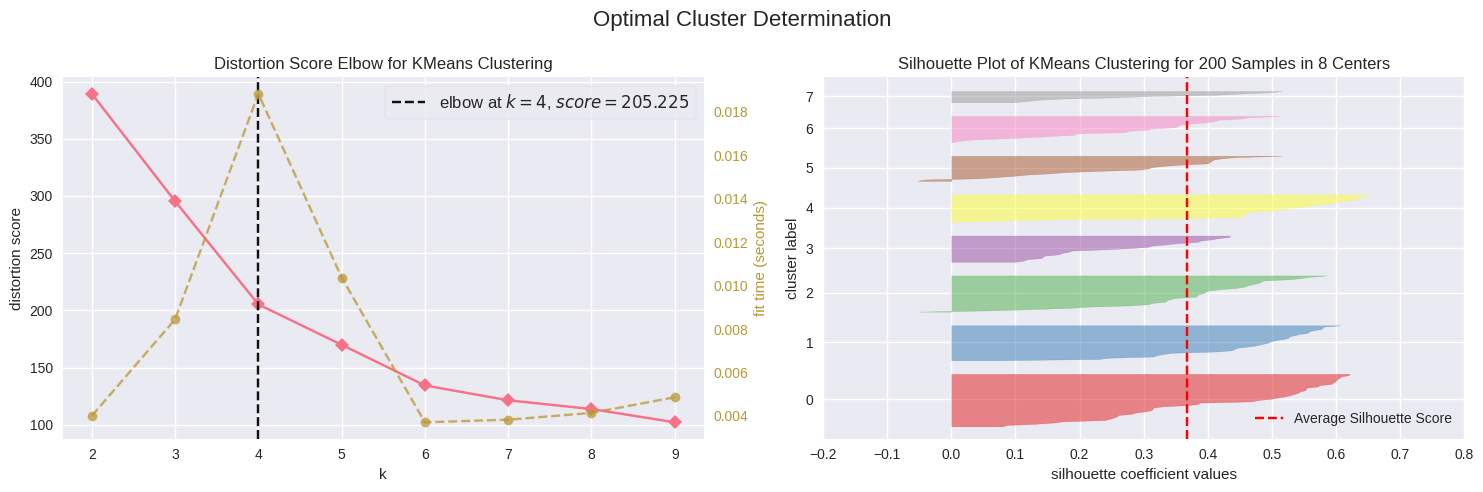


 Generating Hierarchical Clustering Dendrogram...


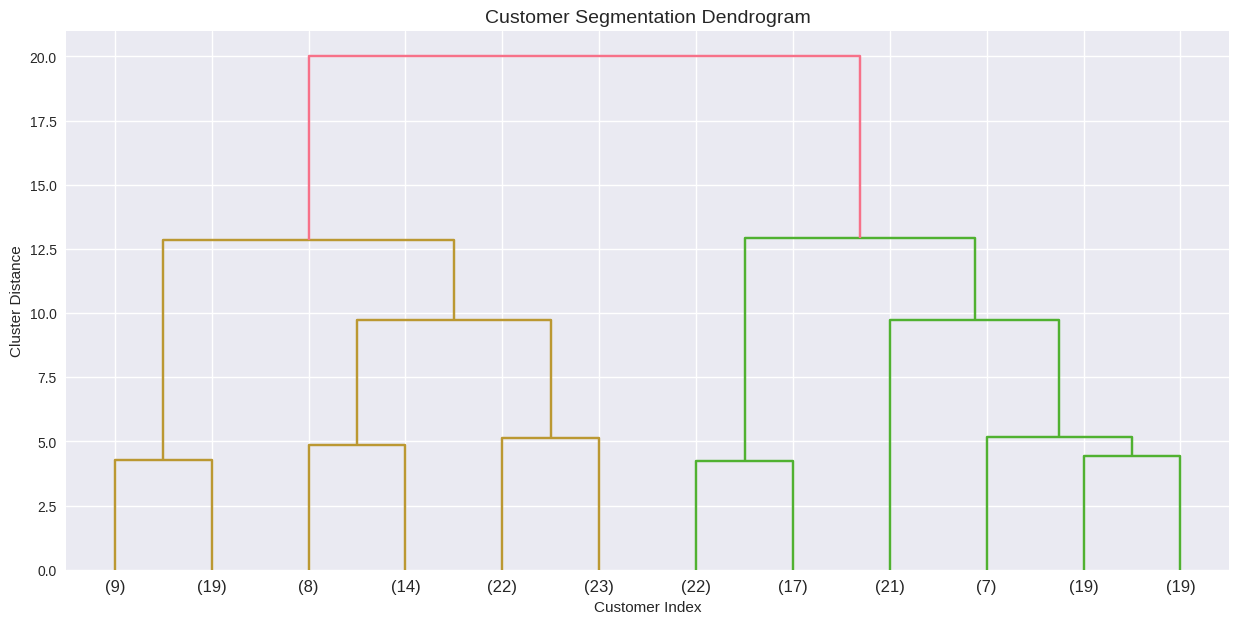


 Running DBSCAN for Outlier Detection...
❗ Detected 60 outliers (30.0% of data)

 Cluster Profiles:


,age,annual_income_k$,spending_score_1-100,gender_dist
cluster,,,,
0,55.275862,47.620690,41.706897,56.9% Female
1,32.875000,86.100000,81.525000,55.0% Female
2,25.769231,26.115385,74.846154,57.7% Female
3,26.733333,54.311111,40.911111,60.0% Female
4,44.387097,89.774194,18.483871,48.4% Female



 Key Business Insights:
 Segment 0: Young, high-spending customers → Target for premium products
 Segment 1: Middle-aged, average income & spending → Focus on value deals
 Segment 2: High-income but low-spending → Potential for loyalty programs
 Segment 3: Young, low-income but high-spending → Watch for credit risk
 Segment 4: Older, low-spending customers → May need reactivation campaigns


In [ ]:

# 1. Setup & Imports
# Install necessary packages
!pip install yellowbrick --quiet
!pip install plotly --quiet

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
import warnings
warnings.filterwarnings("ignore")

# Set visual styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
px.defaults.template = "plotly_dark"
pd.set_option('display.float_format', '{:.2f}'.format)

# 2. Data Loading (Using data from GitHub not from kaggle)

def load_data():
    """Load dataset directly from GitHub with fallback options"""
    urls = [
        "https://raw.githubusercontent.com/plotly/datasets/master/Mall_Customers.csv",
        "https://raw.githubusercontent.com/krishnaik06/DBSCAN-Algorithm/master/Mall_Customers.csv"
    ]

    for url in urls:
        try:
            df = pd.read_csv(url)
            print(f" Successfully loaded data from:\n{url}")
            return df
        except Exception as e:
            print(f"⚠ Failed to load from {url}\nError: {str(e)}")
            continue

    raise Exception("All data sources failed. Please check your internet connection.")

df = load_data()

# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

# Initial inspection
print("\n Data Preview:")
display(df.head())
print(f"\n Data Shape: {df.shape}")
print("\n Missing Values:")
print(df.isna().sum())


# 3. Data Preprocessing

# Convert genre to binary (0=Male, 1=Female)
df['genre'] = df['genre'].map({'Male': 0, 'Female': 1}).astype('int8')

# Select and scale features
features = ['age', 'annual_income_k$', 'spending_score_1-100']
scaler = StandardScaler()
X = scaler.fit_transform(df[features])


# 4. Clustering Analysis

# A. Determine Optimal Clusters
plt.figure(figsize=(15, 5))
plt.suptitle("Optimal Cluster Determination", fontsize=16)

# Elbow Method
plt.subplot(1, 2, 1)
elbow = KElbowVisualizer(KMeans(random_state=42), k=(2, 10))
elbow.fit(X)
elbow.finalize()

# Silhouette Analysis
plt.subplot(1, 2, 2)
silhouette = SilhouetteVisualizer(KMeans(random_state=42), k=(4, 6))
silhouette.fit(X)
silhouette.finalize()

plt.tight_layout()
plt.show()

# B. Hierarchical Clustering
print("\n Generating Hierarchical Clustering Dendrogram...")
plt.figure(figsize=(15, 7))
linked = linkage(X, method='ward')
dendrogram(linked, orientation='top', truncate_mode='lastp', p=12)
plt.title('Customer Segmentation Dendrogram', fontsize=14)
plt.xlabel('Customer Index')
plt.ylabel('Cluster Distance')
plt.show()

# C. DBSCAN Outlier Detection
print("\n Running DBSCAN for Outlier Detection...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['outlier_flag'] = dbscan.fit_predict(X)
outliers = df[df['outlier_flag'] == -1]
print(f"❗ Detected {len(outliers)} outliers ({len(outliers)/len(df):.1%} of data)")



# 5. Final K-Means Clustering

optimal_k = 5  # Determined from visualizations
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Cluster profiles
cluster_profile = df.groupby('cluster').agg({
    'age': 'mean',
    'annual_income_k$': 'mean',
    'spending_score_1-100': 'mean',
    'genre': lambda x: f"{100*(x==1).mean():.1f}% Female"
}).rename(columns={'genre': 'gender_dist'})

print("\n Cluster Profiles:")
display(cluster_profile.style.background_gradient(cmap='Blues'))



# 6. Interactive Visualizations

# 3D Scatter Plot
fig = px.scatter_3d(df,
                    x='age',
                    y='annual_income_k$',
                    z='spending_score_1-100',
                    color='cluster',
                    symbol='genre',
                    hover_data=['age', 'annual_income_k$', 'spending_score_1-100'],
                    title="<b>3D Customer Segmentation</b>",
                    labels={'cluster': 'Segment'},
                    color_discrete_sequence=px.colors.qualitative.Vivid)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
fig.show()

# Parallel Coordinates Plot
fig = px.parallel_coordinates(df,
                             dimensions=features,
                             color='cluster',
                             title="<b>Parallel Coordinates Analysis</b>")
fig.show()



# 7. Business Insights

print("\n Key Business Insights:")
insights = {
    0: "Young, high-spending customers → Target for premium products",
    1: "Middle-aged, average income & spending → Focus on value deals",
    2: "High-income but low-spending → Potential for loyalty programs",
    3: "Young, low-income but high-spending → Watch for credit risk",
    4: "Older, low-spending customers → May need reactivation campaigns"
}

for cluster, insight in insights.items():
    print(f" Segment {cluster}: {insight}")